In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import seaborn as sns
sns.set_theme(style='whitegrid')

In [2]:
X_train = torch.load('datasets/gds_as_tensors/X_train.pt')
y_train = torch.load('datasets/gds_as_tensors/y_train.pt')
X_test = torch.load('datasets/gds_as_tensors/X_test.pt')
y_test = torch.load('datasets/gds_as_tensors/y_test.pt')

In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = y_train.squeeze(1).type(torch.LongTensor)
y_test = y_test.squeeze(1).type(torch.LongTensor)

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
def train(X, y, model, device, optimizer, criterion, i):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    
    predictions = []
    correct = 0
    
    
    
        
    optimizer.zero_grad()    
    # Do forward pass for current set of data
    output = model(X)
        
    pred = output.argmax(dim=1, keepdim=True)
    
    
    loss = criterion(output, y)
        
    # Computes gradient based on final loss
    loss.backward()
        
    
        
    # Optimize model parameters based on learning rate and gradient 
    optimizer.step()
        
    # Get predicted index by selecting maximum log-probability
    correct = pred.eq(y.data.view_as(pred)).sum()
    predictions.append(pred)
    train_loss = loss.item()
    train_acc = correct / len(y)
    
    if i % 50 == 0:
        print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss.item(), correct, len(y),
            100. * correct / len(y)))
    
    return train_loss, train_acc, predictions
    


def test(X, y, model, device, criterion, i):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    predictions = []
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        
            

        # Predict for data by doing forward pass
        output = model(X)
        # Compute loss based on same criterion as training 
        loss = criterion(output, y)
            
        # Append loss to overall test loss
        losses.append(loss.item())
        
          
        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)
           
        # =======================   ===============================================
        # Count correct predictions overall#
        predictions.append(pred)
        
        correct = pred.eq(y.data.view_as(pred)).sum()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(y)
    if i % 50 == 0:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(y), accuracy))
        
    return test_loss, accuracy, predictions


In [6]:
def plot_all_losses(train_l=None, test_l=None, train_ac=None, test_ac=None, title=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), dpi=100)
    
    if title:
        fig.suptitle(title)
    if train_l:
        axes[0][0].plot(train_l)
        axes[0][0].set_title("Training Loss")
    if test_l:
        axes[0][1].plot(test_l)
        axes[0][1].set_title("Test Loss")
    if train_ac:
        axes[1][0].plot(train_ac)
        axes[1][0].set_title("Training Accuracy")
    if test_ac:
        axes[1][1].plot(test_ac)
        axes[1][1].set_title("Test Accuracy")

    plt.tight_layout()


In [7]:
def run_main():
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()
    
    # Set proper device based onr cuda availability 
    device = torch.device("cpu") #torch.device("cuda" if use_cuda else "cpu") 
    print("Torch device selected: ", device)
    
    # Initialize the model and send to device 
    model = Net().to(device)

    
    criterion = nn.CrossEntropyLoss()
    
    # ======================================================================
    # Define optimizer function.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
    
    training_losses = []
    test_losses = []
    training_accuracies = []
    testing_accuracies = []
    y_pred_train = []
    y_pred_test = []
    
    best_train_accuracy = 0.0
    best_test_accuracy = 0.0
    
    # Run training for n_epochs specified in config 
    for epoch in range(1, 500):
        train_loss, train_accuracy, y_pred_train = train(X_train, y_train, model, device,
                                            optimizer, criterion, epoch)
        test_loss, test_accuracy, y_pred_test = test(X_test, y_test, model, device, criterion, epoch)
        
        
        training_losses.append(train_loss)
        test_losses.append(test_loss)
        training_accuracies.append(train_accuracy)
        testing_accuracies.append(test_accuracy)
        
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
    
    
    print("best train accuracy is {:2.2f}".format(best_train_accuracy))
    print("best test accuracy is {:2.2f}".format(best_test_accuracy))
    
    print("Training loss after training: {:2.2f}".format(train_loss))
    print("Test loss after training: {:2.2f}".format(test_loss))


    print("Training and evaluation finished")
    
    plot_all_losses(training_losses, test_losses, training_accuracies, testing_accuracies)
    
    return y_pred_test, y_pred_train
    


Torch device selected:  cpu
Train set: Average loss: 0.1252, Accuracy: 3705/3840 (96%)


Test set: Average loss: 0.1571, Accuracy: 919/960 (96%)

Train set: Average loss: 0.0097, Accuracy: 3834/3840 (100%)


Test set: Average loss: 0.0693, Accuracy: 945/960 (98%)

Train set: Average loss: 0.0020, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.0818, Accuracy: 944/960 (98%)

Train set: Average loss: 0.0008, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.0905, Accuracy: 944/960 (98%)

Train set: Average loss: 0.0004, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.0956, Accuracy: 946/960 (99%)

Train set: Average loss: 0.0003, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.1015, Accuracy: 944/960 (98%)

Train set: Average loss: 0.0002, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.1048, Accuracy: 943/960 (98%)

Train set: Average loss: 0.0001, Accuracy: 3840/3840 (100%)


Test set: Average loss: 0.1080, Accuracy: 943/960 (98%)

Train set: Average lo

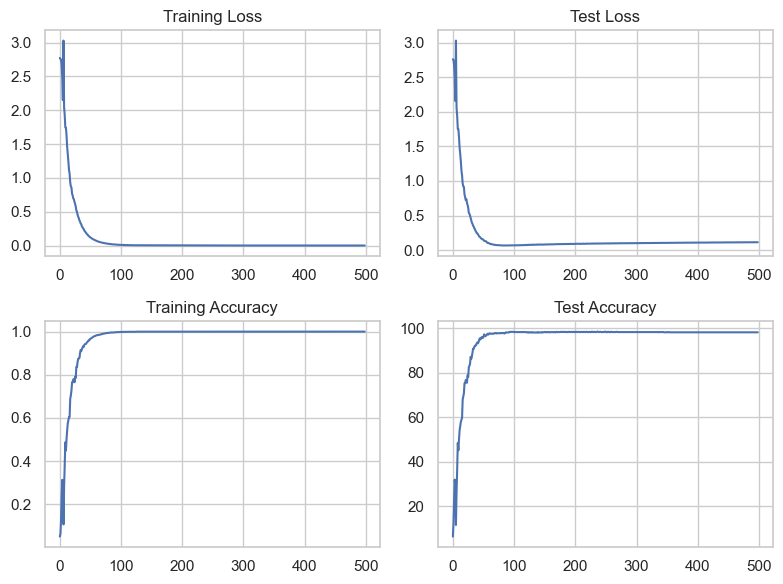

In [8]:
import time
time_start = time.perf_counter()
y_pred_test, y_pred_train = run_main()
time_end = time.perf_counter()
time_difference = time_end - time_start
print(time_difference)

In [10]:
y_pred = y_pred_test[0].numpy()
y_test = y_test.numpy()

(-0.5, 15.5, 15.5, -0.5)

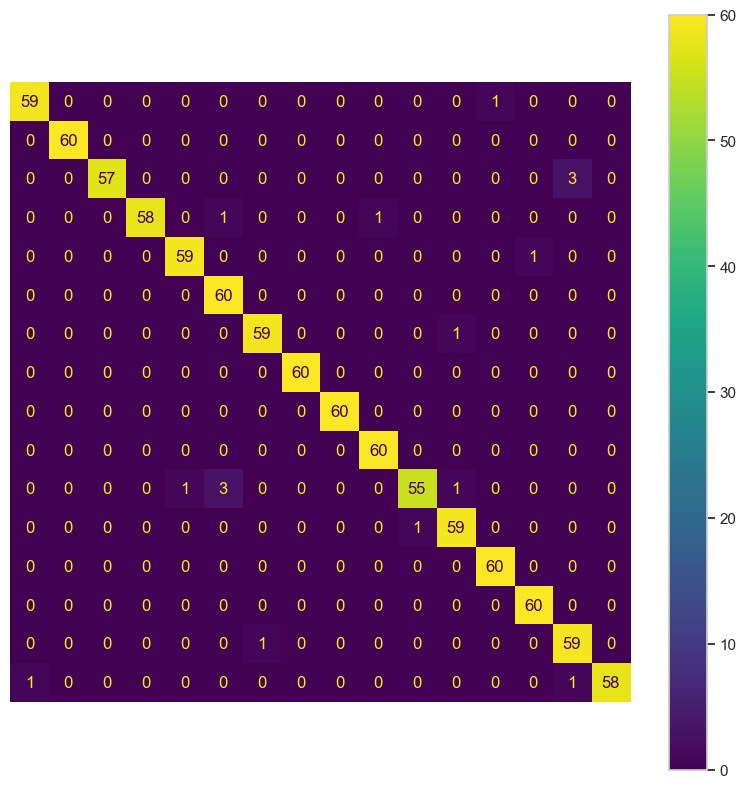

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
disp.plot(ax=ax)
plt.axis('off')